# Predicción Precio Acciones de Mercado

## 1. Contenido <a name="content"></a> <a id='back'></a>

* [1 Contenido](#content)
* [2 Introducción](#intro)
* [3 Inicialización](#inic)
    * [3.1 Cargar Librerias](#library)
    * [3.2 Cargar Datos](#data)
* [4 Análisis de los datos](#analysis) 
* [5 Definiciónes](#def)
    * [5.1 Definición de Variables](#var)
    * [5.2 Definir Target](#target)
    * [5.3 Definir Features](#features)
* [6 Funciones](#function)
* [7 Modelo](#model)
* [8 Compañias Recomendadas](#recomen)
* [9 Evaluación](#eval)

## 2. Introducción <a name="intro"></a>

 En el presente proyecto desarrollaremos un modelo de machine learning, específicamente una red neuronal, con el objetivo de poder predecir el valor futuro de las acciones de distintas compañías, crear un portafolio de empresas con los mejores rendimientos esperados y comprobar si este último logra tener un rendimiento mayor que el S&P500. Se utilizarán datos desde diciembre del 2010 hasta agosto del 2022, concretamente se realizará la predicción en enero del 2022 y se utilizará el resto de los datos para comprobar como hubiera sido nuestro rendimiento si hubiéramos invertido en la fecha de la predicción.

 Como variable objetivo a predecir se decidió utilizar la variación de precio que tendrá una acción con respecto a 60 días en el futuro.

## 3. Inicialización <a name="inic"></a>

### 3.1. Cargar Librerias <a name="library"></a>

Se procede con la carga de las librerías que se utilizarán en el proyecto.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
import numpy as np
import time
np.random.seed(12345)

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler

from datetime import datetime
import statistics

from tensorflow import keras

Incluimos un contador de tiempo para saber cuánto demora la ejecución del problema.

In [2]:
start_time = time.time()

### 3.2. Cargar Datos <a name="data"></a>

Procedemos con la carga de las bases de datos.

In [2]:
df_stock = pd.read_parquet('datasets/company_stock_data.parquet')
df_index = pd.read_parquet('datasets/index_sector_data.parquet')

[Volver a Contenidos](#back)

## 4. Análisis de los Datos <a name="analysis"></a>

Comenzaremos con una visualización de la principal base de datos a utilizar, la que posee los datos del valor de las acciones de las empresas.

In [3]:
df_stock.head()

,Dates,PX_LAST,BEST_TARGET_PRICE,BEST_ANALYST_RATING,TOT_BUY_REC,TOT_HOLD_REC,TOT_SELL_REC,BEST_PE_RATIO,BEST_EV_TO_BEST_EBITDA,BEST_PX_BPS_RATIO,company
0,2010-12-31,27.92,NaN,4.514,28.0,9.0,0.0,NaN,NaN,NaN,MSFT
1,2011-01-03,27.98,32.775,4.514,28.0,9.0,0.0,NaN,NaN,NaN,MSFT
2,2011-01-04,28.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MSFT
3,2011-01-05,28.00,32.775,4.514,28.0,9.0,0.0,NaN,NaN,NaN,MSFT
4,2011-01-06,28.80,32.775,4.514,28.0,9.0,0.0,NaN,NaN,NaN,MSFT


In [4]:
df_stock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75221 entries, 0 to 75220
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Dates                   75221 non-null  datetime64[ns]
 1   PX_LAST                 72515 non-null  float64       
 2   BEST_TARGET_PRICE       53515 non-null  float64       
 3   BEST_ANALYST_RATING     56764 non-null  float64       
 4   TOT_BUY_REC             56765 non-null  float64       
 5   TOT_HOLD_REC            56765 non-null  float64       
 6   TOT_SELL_REC            56765 non-null  float64       
 7   BEST_PE_RATIO           12752 non-null  float64       
 8   BEST_EV_TO_BEST_EBITDA  10191 non-null  float64       
 9   BEST_PX_BPS_RATIO       12364 non-null  float64       
 10  company                 75221 non-null  object        
dtypes: datetime64[ns](1), float64(9), object(1)
memory usage: 6.3+ MB


Comenzamos observando la primera base de datos, esta se compone con los valores de las acciones de las distintas compañías a predecir, compras y ventas de las mismas, además de ratios de índices de las compañías. podemos observar la existencia de datos nulos en prácticamente todas las columnas excepto las fechas y a que compañía corresponde la fila, es de notar que las columnas "BEST_PE_RATIO", "BEST_EV_TO_BEST_EBITDA" y "BEST_PX_BPS_RATIO" poseen más de un 80% de valores nulos.

In [5]:
min(df_stock['Dates'])

Timestamp('2010-12-31 00:00:00')

In [6]:
max(df_stock['Dates'])

Timestamp('2022-08-18 00:00:00')

Podemos observar que los datos van desde diciembre del 2012 hasta agosto del 2022, abarcando casi 12 años.

Se procede a definir una variable con los nombre de todas las compañias.

In [7]:
companies = df_stock['company'].unique()

A continuación, observaremos el valor de las acciones de las distintas empresas y del S&P 500 a través de los años.

<AxesSubplot:xlabel='Dates'>

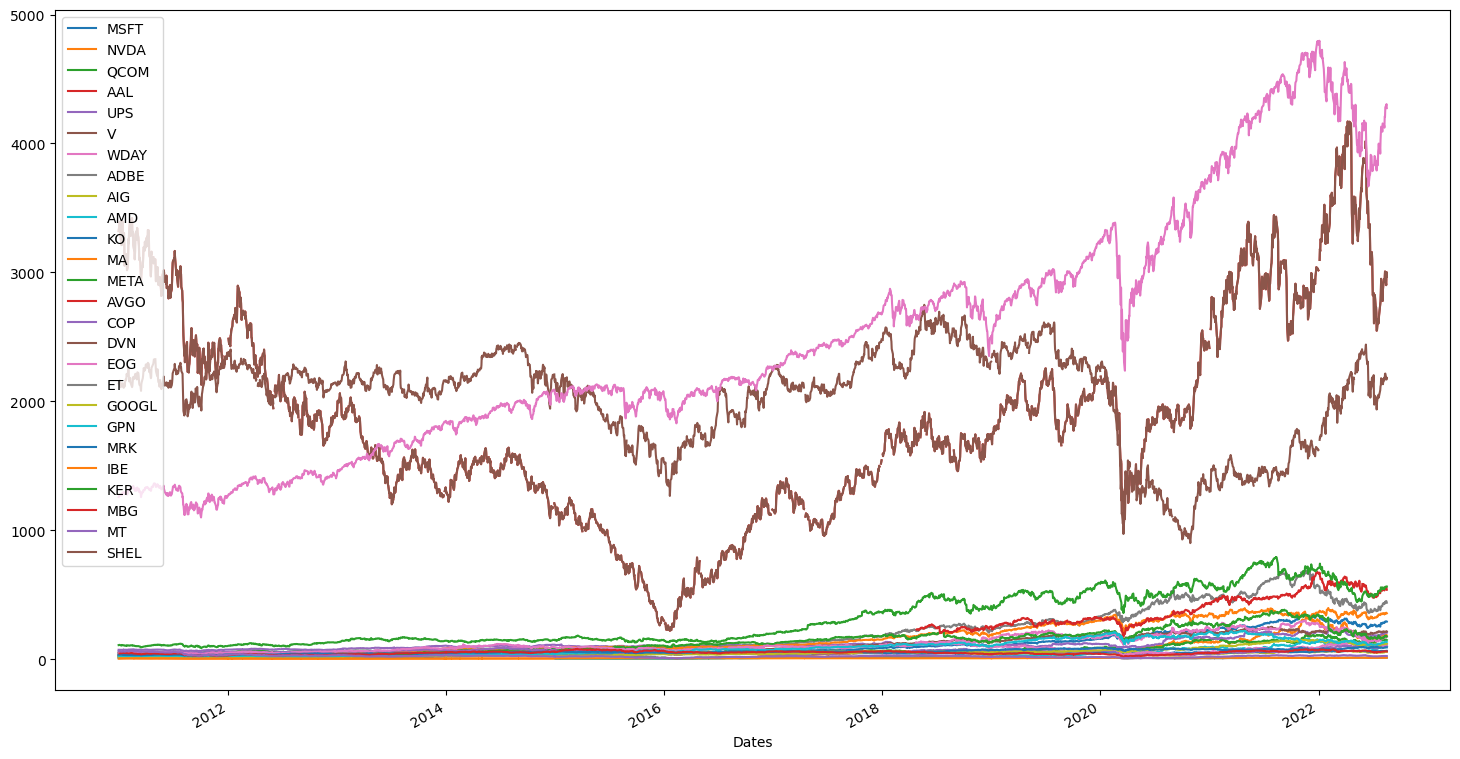

In [8]:
df_infex2 = df_index.set_index("Dates")
df_stock2 = df_stock.set_index("Dates")
date="2010-12-31"
df_infex2 = df_infex2.query(f"(index >= '{date}')")
for stock in companies:
    df_stock2[df_stock2['company']== stock]['PX_LAST'].plot(figsize = [18,10])
    plt.legend(companies)
df_infex2["SPX INDEX_PX_LAST"].plot(figsize = [18,10])

Observamos que desde el 2015 el S&P 500 posee un valor unitario de acciones superior a cualquiera de las empresas y que todos los valores han caído desde comienzos del 2021

[Volver a Contenidos](#back)

## 5. Definiciónes <a name="def"></a>

### 5.1. Definición de Variables <a name="var"></a>

Procederemos a definir variables que se utilizaran durante la ejecución del modelo. Comenzando con la ventana de tiempo que predecirá el modelo.

In [9]:
target_window = 60

Continuamos definiendo una serie de variables temporales.

In [10]:
train_start_date = "2012-01-01"
train_end_date = "2021-06-14"
validation_start_date = "2021-06-15"
validation_end_date = "2022-01-01"
start_date_for_plot = '2015-01-01'
prediction_date ="2022-01-04"
prediction_date_end = "2022-08-18"
visual_start_date = "2020-01-01"

In [11]:
n_future = (datetime.strptime(validation_end_date, "%Y-%m-%d")-datetime.strptime(validation_start_date, "%Y-%m-%d")).days
n_past = 60
n_future

200

Definiremos un valor de inversión en dolares

In [12]:
usd_inversion=1000

### 5.2. Definir Target <a name="target"></a>

Se define el target del modelo como la variación de precios de la acción de la compañía con respecto la ventana de días determinada en la sección anterior.

In [13]:
target_name = f"target_{target_window}d"

In [14]:
def create_relative_target(df):

    target_df = df.copy()

    target_df[target_name] = 100 * (target_df["PX_LAST"].shift(-target_window) / target_df["PX_LAST"] - 1)

    return target_df

### 5.3. Definir Features <a name="features"></a>

Se procede a crear la base de datos con sus inputs finales.

In [15]:
# features de solo PX_LAST

features_dfs = {}

for stock in companies:
    features_df = df_stock.query("company == @stock")
    features_df = features_df.set_index("Dates")
    features_df = create_relative_target(features_df)
    features_df = features_df.drop(["BEST_TARGET_PRICE", "BEST_ANALYST_RATING", "TOT_BUY_REC", "TOT_HOLD_REC", "TOT_SELL_REC", "BEST_PE_RATIO", "BEST_EV_TO_BEST_EBITDA", "BEST_PX_BPS_RATIO", "company"], axis=1)
    features_df = features_df.ffill(axis=0)
    features_df = features_df.dropna()
    
    features_dfs.update({stock: features_df})

[Volver a Contenidos](#back)

## 6. Funciones <a name="function"></a>

A continuación crearemos una serie de funciones que se utilizaran durante la ejecución del proyecto.

In [16]:
# Creación del set de entrenamiento

def training(training_df, input_df):
    for stock in companies:
        tmp_df = input_df[stock]
        training = tmp_df.query(f"(index >= '{train_start_date}') and (index < '{train_end_date}')")
        training_df.update({stock: training})

In [17]:
# Función de escalado de valores
sc = MinMaxScaler(feature_range=(0,1))
def scaling(scaling_df, input_df):

    for stock in companies:
        tmp_df = input_df[stock].drop("PX_LAST", axis=1)
        scaler = sc.fit_transform(tmp_df)
        scaling_df.update({stock: scaler})

In [18]:
# estructura de datos de 60 timesteps y 1 salida

def train_X_y(input_x, input_y, scaling_input, training_input):

    for stock in companies:
        X_train = []
        for i in range(n_past, training_input[stock].drop("PX_LAST", axis=1).shape[0]):
            X_train.append(scaling_input[stock][i - n_past:i, 0])
        X_train = np.array(X_train)
        input_x.update({stock: X_train})

    for stock in companies:
        y_train = []
        for i in range(n_past, training_input[stock].drop("PX_LAST", axis=1).shape[0]):
            y_train.append(scaling_input[stock][i,0])
        y_train = np.array(y_train)
        input_y.update({stock: y_train})

In [19]:
# Modelo

def train_model_neuronal(input_x, input_y, neurons, activation, epoch):

    model = Sequential()
    model.add(LSTM(units=neurons, return_sequences=True, input_shape=(input_x.shape[1], 1), activation=activation))
    model.add(Dropout(0.2))
    model.add(LSTM(units=neurons, activation=activation))
    model.add(Dropout(0.2))
    model.add(Dense(units=1, activation=activation))
    model.compile(optimizer='adam', loss='mean_absolute_error')
    
    model.fit(input_x, input_y, epochs=epoch, batch_size=32)
    return model

In [20]:
# Generador de modelo

def model_gen(models, train_model,x,y, neurons, activation, epoch):
    
    for stock in companies:
        tmp_x = x[stock]
        tmp_y = y[stock]
        model = train_model(tmp_x,tmp_y, neurons, activation, epoch)
        models.update({stock: model})

In [21]:
# Generador de sequencias de dias

def datelist(input_datelist_train, input_datelist_future, input_features):
    for stock in companies:
        datelist_train =  list(input_features[stock].query(f"(index >= '{train_start_date}') and (index < '{train_end_date}')").index)
        datelist_future = pd.date_range(datelist_train[-1], periods=n_future, freq='1d').tolist()
        datelist_future_ = []
        for this_timestamp in datelist_future:
            datelist_future_.append(this_timestamp.date())
        input_datelist_future.update({stock: datelist_future})
        input_datelist_train.update({stock: datelist_train})

In [22]:
# Generador de predicciones

def prediction(pred_future_df, pred_train_df):
    for stock in companies:
        predictions_future = models[stock].predict(X_train_df[stock][-n_future:])
        predictions_train = models[stock].predict(X_train_df[stock][n_past:])
        pred_future_df.update({stock: predictions_future}) 
        pred_train_df.update({stock: predictions_train}) 

In [23]:
# Convertidor de datetime to timestamp

def datetime_to_timestamp(x):
    return datetime.strptime(x.strftime('%Y%m%d'), '%Y%m%d')

In [24]:
# Retornador de predicciones a medidas originales

def returner(re_pred_f_df, re_pred_train_df, pred_train_df, pred_future_df):
    for stock in companies:
        y_pred_future = sc.inverse_transform(pred_future_df[stock])
        y_pred_train = sc.inverse_transform(pred_train_df[stock])

        PREDICTION_FUTURE = pd.DataFrame(y_pred_future, columns=[target_name]).set_index(pd.Series(datelist_future_df[stock]))
        PREDICTION_TRAIN = pd.DataFrame(y_pred_train, columns=[target_name]).set_index(pd.Series(datelist_train_df[stock][n_past + n_future-140:]))

        PREDICTION_TRAIN.index = PREDICTION_TRAIN.index.to_series().apply(datetime_to_timestamp)
        re_pred_train_df.update({stock: PREDICTION_TRAIN})
        re_pred_f_df.update({stock: pd.DataFrame(data={
                                 "target": features_dfs[stock].query(f"(index >= '{datelist_future_df[stock][0]}') and (index <= '{datelist_future_df[stock][n_future-1]}')")[target_name],
                                 "prediction": PREDICTION_FUTURE[target_name]},
                                index=features_dfs[stock].query(f"(index >= '{datelist_future_df[stock][0]}') and (index <= '{datelist_future_df[stock][n_future-1]}')").index)})

In [25]:
# Grafico

def graph(re_pred_f_df, re_pred_train_df, input_features):
    for stock in companies:
        plt.plot(re_pred_f_df[stock].index, re_pred_f_df[stock]['prediction'], color='r', label='Predicted Stock Price')
        plt.plot(re_pred_train_df[stock].loc[start_date_for_plot:].index, re_pred_train_df[stock].loc[start_date_for_plot:][target_name], color='orange', label='Training predictions')
        plt.plot(input_features[stock].loc[start_date_for_plot:].index, input_features[stock].loc[start_date_for_plot:][target_name], color='b', label='Actual Stock Price')

        plt.axvline(x = min(re_pred_f_df[stock].index), color='green', linewidth=2, linestyle='--')
        plt.axvline(x=pd.to_datetime(validation_end_date), color='brown', linewidth=2, linestyle='--')

        plt.grid(which='major', color='#cccccc', alpha=0.5)

        plt.legend(shadow=True)
        plt.title(stock, family='Arial', fontsize=12)
        plt.xlabel('Timeline', family='Arial', fontsize=10)
        plt.ylabel('Stock Variation Value', family='Arial', fontsize=10)
        plt.xticks(rotation=45, fontsize=8)
        plt.show()

In [26]:
# Error SMAPE

def smape(prediction, error):
    for stock in companies:
        list = (prediction[stock].prediction-prediction[stock].target).abs().div((prediction[stock].target+prediction[stock].prediction)/2)
        promedio = list.mean()
        error.update({stock: promedio})
    res = statistics.median(error.values())
    return res

In [91]:
# Ranking

def results(final_result, predictions, number_companies, price, volatility):
    for stock in companies:
        final_result.update({stock: predictions[stock]['prediction'][-1]})
    dfinal = pd.DataFrame([final_result]).transpose().reset_index() 
    dfinal.columns = ['company','price_variation_%']
    for stock in companies:
        vol_df = features_dfs[stock]
        vol_df['Log returns'] = np.log(vol_df['PX_LAST']/vol_df['PX_LAST'].shift())
        dfinal.loc[dfinal['company']==stock,'volatility_%'] = vol_df['Log returns'].std()*100
    dfinal['total_rank'] = round(dfinal['price_variation_%']*price-dfinal['volatility_%']*volatility)
    ranked_companies = dfinal.sort_values(by=['total_rank'], ascending=[False]).head(number_companies)
    ranked_companies.loc[ranked_companies['total_rank']<=0,'total_rank'] = 0
    ranked_companies['investment_%'] = ranked_companies['total_rank']/sum(ranked_companies['total_rank'])*100
  
    return ranked_companies

In [28]:
# Creación de portfolio

def portfolio_creation(input_result, input_portfolio, input_features):
    portfolio = list(input_result['company'])
    
    for stock in portfolio:
        input_portfolio.update({
        stock: pd.DataFrame(data={
        "index": input_features[stock]["PX_LAST"]*((input_result.loc[input_result['company']==stock,'investment_%'].values)/100),
        "dates": input_features[stock].index,
        "name": ["portfolio"] * len(input_features[stock])})})
        
    df = pd.concat(input_portfolio, axis=1).dropna()
    df_2 =df.groupby(level=[0]).sum()
    df_2.columns=df_2.columns.droplevel()
    df_3=df_2.loc[:,:].sum(axis=1)
    df_4 = pd.DataFrame(data=df_3, columns=['index'])
    df_4=df_4.reset_index()
    df_4['name'] = 'portfolio'
    df_4.rename(columns = {'Dates':'dates'}, inplace = True)
    return df_4

In [29]:
# Resumen final

def resume(input_result):
    total_volatility = sum((input_result['volatility_%']/100)*(input_result['investment_%']/100)*100)
    total_income = sum((input_result['price_variation_%']/100)*(input_result['investment_%']/100)*100)
    total_money = ((total_income/100)+1)*usd_inversion
    d = {'income_%': [round(total_income,2)], 'volatility_%': [round(total_volatility,2)], 'usd_tot': [round(total_money,2)]}
    final_resume=pd.DataFrame(data=d)
    return final_resume

In [30]:
# Rendimiento diario

def daily_yield(prediction_date, pred_end_date, input_portfolio, input_benchmark):
    import datetime
    prediction_start = datetime.datetime.strptime(prediction_date, "%Y-%m-%d")
    prediction_end = datetime.datetime.strptime(pred_end_date, "%Y-%m-%d")

    portfolio_base_px = input_portfolio.loc[input_portfolio["dates"] == prediction_date]["index"].values[0]
    benchmark_base_px = input_benchmark.loc[input_benchmark["dates"] == prediction_date]["index"].values[0]

    decision_portfolio = input_portfolio.query(f"(dates >= '{prediction_date}') and (dates <= '{prediction_end}')").assign(base_px=portfolio_base_px)
    decision_benchmark = input_benchmark.query(f"(dates >= '{prediction_date}') and (dates <= '{prediction_end}')").assign(base_px=benchmark_base_px)

    decision_portfolio["daily_yield"] = decision_portfolio["index"] / decision_portfolio["base_px"]
    decision_benchmark["daily_yield"] = decision_benchmark["index"] / decision_benchmark["base_px"]

    all_evals_df = pd.concat([decision_portfolio,decision_benchmark])
    return all_evals_df

In [31]:
# Función para guardar la matriz de modelos ya entrenados "models"
# Esta función guardara todos los modelos de forma independiente con el nombre de su empresa correspondiente para poder
# cargarlos a futuro con el entrenamiento ya realizado y por ende obteniendo los mimos resultados al ejecutarlo

def save_models(input_models):
    for stock in companies:
        input_models[stock].save(f"{stock}.h5")

In [32]:
# Función para cargar los modelos ya entrenados
# Con esta función cargaremos modelos ya entrenados para obtener los mismos resultados, procedermos a saltarnos el paso en que se
#usa la función model_gen y en su lugar utilizaremos esta función, creando previamente la variable models={}, los modelos ya 
#entrenados deben de encontrarse en la misma carpeta que este modelo.

def load_models(input_models):
    for stock in companies:
         input_models.update({stock: keras.models.load_model(f"{stock}.h5")})

[Volver a Contenidos](#back)

## 7. Modelo <a name="model"></a>

In [33]:
#Procedemos a crear el training set

training_dfs = {}
training(training_dfs,features_dfs)

In [34]:
#Procedemos con el escalado

scaling_dfs = {}
scaling(scaling_dfs,training_dfs)

In [35]:
#Procedemos a crear los datos de entrenamiento

X_train_df = {}
y_train_df = {}
train_X_y(X_train_df, y_train_df, scaling_dfs, training_dfs)

In [38]:
#En caso de querer cargar modelos continuamos con esta función y nos saltamos el siguiente paso
#models = {}
#load_models(models)

In [35]:
#Procedemos a correr el modelo

models = {}
model_gen(models, train_model_neuronal,X_train_df,y_train_df,36,'tanh',70)

Epoch 1/70
74/74 [==============================] - 4s 20ms/step - loss: 0.0836
Epoch 2/70
74/74 [==============================] - 1s 20ms/step - loss: 0.0582
Epoch 3/70
74/74 [==============================] - 1s 20ms/step - loss: 0.0557
Epoch 4/70
74/74 [==============================] - 1s 20ms/step - loss: 0.0514
Epoch 5/70
74/74 [==============================] - 2s 21ms/step - loss: 0.0513
Epoch 6/70
74/74 [==============================] - 1s 20ms/step - loss: 0.0484
Epoch 7/70
74/74 [==============================] - 1s 20ms/step - loss: 0.0481
Epoch 8/70
74/74 [==============================] - 1s 20ms/step - loss: 0.0473
Epoch 9/70
74/74 [==============================] - 1s 19ms/step - loss: 0.0443
Epoch 10/70
74/74 [==============================] - 1s 19ms/step - loss: 0.0444
Epoch 11/70
74/74 [==============================] - 1s 19ms/step - loss: 0.0433
Epoch 12/70
74/74 [==============================] - 1s 19ms/step - loss: 0.0422
Epoch 13/70
74/74 [==================

74/74 [==============================] - 1s 20ms/step - loss: 0.0217
Epoch 64/70
74/74 [==============================] - 2s 20ms/step - loss: 0.0218
Epoch 65/70
74/74 [==============================] - 2s 21ms/step - loss: 0.0219
Epoch 66/70
74/74 [==============================] - 1s 20ms/step - loss: 0.0222
Epoch 67/70
74/74 [==============================] - 1s 19ms/step - loss: 0.0221
Epoch 68/70
74/74 [==============================] - 1s 19ms/step - loss: 0.0223
Epoch 69/70
74/74 [==============================] - 2s 21ms/step - loss: 0.0220
Epoch 70/70
74/74 [==============================] - 2s 22ms/step - loss: 0.0221
Epoch 1/70
74/74 [==============================] - 4s 20ms/step - loss: 0.0470
Epoch 2/70
74/74 [==============================] - 1s 20ms/step - loss: 0.0278
Epoch 3/70
74/74 [==============================] - 2s 21ms/step - loss: 0.0260
Epoch 4/70
74/74 [==============================] - 2s 21ms/step - loss: 0.0243
Epoch 5/70
74/74 [==========================

74/74 [==============================] - 1s 19ms/step - loss: 0.0262
Epoch 56/70
74/74 [==============================] - 1s 19ms/step - loss: 0.0258
Epoch 57/70
74/74 [==============================] - 2s 20ms/step - loss: 0.0259
Epoch 58/70
74/74 [==============================] - 2s 20ms/step - loss: 0.0262
Epoch 59/70
74/74 [==============================] - 1s 19ms/step - loss: 0.0256
Epoch 60/70
74/74 [==============================] - 1s 19ms/step - loss: 0.0257
Epoch 61/70
74/74 [==============================] - 1s 19ms/step - loss: 0.0254
Epoch 62/70
74/74 [==============================] - 1s 19ms/step - loss: 0.0262
Epoch 63/70
74/74 [==============================] - 1s 19ms/step - loss: 0.0253
Epoch 64/70
74/74 [==============================] - 1s 19ms/step - loss: 0.0253
Epoch 65/70
74/74 [==============================] - 1s 19ms/step - loss: 0.0255
Epoch 66/70
74/74 [==============================] - 1s 19ms/step - loss: 0.0257
Epoch 67/70
74/74 [=====================

74/74 [==============================] - 1s 20ms/step - loss: 0.0196
Epoch 48/70
74/74 [==============================] - 1s 20ms/step - loss: 0.0193
Epoch 49/70
74/74 [==============================] - 2s 21ms/step - loss: 0.0187
Epoch 50/70
74/74 [==============================] - 1s 20ms/step - loss: 0.0181
Epoch 51/70
74/74 [==============================] - 1s 19ms/step - loss: 0.0184
Epoch 52/70
74/74 [==============================] - 1s 19ms/step - loss: 0.0188
Epoch 53/70
74/74 [==============================] - 1s 20ms/step - loss: 0.0177
Epoch 54/70
74/74 [==============================] - 1s 20ms/step - loss: 0.0180
Epoch 55/70
74/74 [==============================] - 1s 19ms/step - loss: 0.0178
Epoch 56/70
74/74 [==============================] - 1s 19ms/step - loss: 0.0179
Epoch 57/70
74/74 [==============================] - 1s 20ms/step - loss: 0.0175
Epoch 58/70
74/74 [==============================] - 1s 19ms/step - loss: 0.0171
Epoch 59/70
74/74 [=====================

74/74 [==============================] - 1s 20ms/step - loss: 0.0265
Epoch 40/70
74/74 [==============================] - 1s 20ms/step - loss: 0.0268
Epoch 41/70
74/74 [==============================] - 1s 20ms/step - loss: 0.0258
Epoch 42/70
74/74 [==============================] - 2s 21ms/step - loss: 0.0257
Epoch 43/70
74/74 [==============================] - 1s 20ms/step - loss: 0.0258
Epoch 44/70
74/74 [==============================] - 1s 20ms/step - loss: 0.0261
Epoch 45/70
74/74 [==============================] - 1s 20ms/step - loss: 0.0260
Epoch 46/70
74/74 [==============================] - 1s 19ms/step - loss: 0.0256
Epoch 47/70
74/74 [==============================] - 1s 19ms/step - loss: 0.0256
Epoch 48/70
74/74 [==============================] - 1s 20ms/step - loss: 0.0251
Epoch 49/70
74/74 [==============================] - 1s 20ms/step - loss: 0.0249
Epoch 50/70
74/74 [==============================] - 1s 19ms/step - loss: 0.0251
Epoch 51/70
74/74 [=====================

74/74 [==============================] - 1s 19ms/step - loss: 0.0190
Epoch 32/70
74/74 [==============================] - 1s 20ms/step - loss: 0.0191
Epoch 33/70
74/74 [==============================] - 1s 20ms/step - loss: 0.0190
Epoch 34/70
74/74 [==============================] - 1s 19ms/step - loss: 0.0191
Epoch 35/70
74/74 [==============================] - 1s 19ms/step - loss: 0.0187
Epoch 36/70
74/74 [==============================] - 1s 20ms/step - loss: 0.0181
Epoch 37/70
74/74 [==============================] - 1s 20ms/step - loss: 0.0177
Epoch 38/70
74/74 [==============================] - 1s 19ms/step - loss: 0.0177
Epoch 39/70
74/74 [==============================] - 1s 20ms/step - loss: 0.0175
Epoch 40/70
74/74 [==============================] - 2s 21ms/step - loss: 0.0173
Epoch 41/70
74/74 [==============================] - 1s 20ms/step - loss: 0.0169
Epoch 42/70
74/74 [==============================] - 1s 19ms/step - loss: 0.0171
Epoch 43/70
74/74 [=====================

73/73 [==============================] - 1s 19ms/step - loss: 0.0158
Epoch 24/70
73/73 [==============================] - 1s 20ms/step - loss: 0.0159
Epoch 25/70
73/73 [==============================] - 1s 20ms/step - loss: 0.0153
Epoch 26/70
73/73 [==============================] - 1s 20ms/step - loss: 0.0152
Epoch 27/70
73/73 [==============================] - 1s 19ms/step - loss: 0.0146
Epoch 28/70
73/73 [==============================] - 1s 19ms/step - loss: 0.0152
Epoch 29/70
73/73 [==============================] - 1s 20ms/step - loss: 0.0145
Epoch 30/70
73/73 [==============================] - 1s 19ms/step - loss: 0.0141
Epoch 31/70
73/73 [==============================] - 1s 20ms/step - loss: 0.0146
Epoch 32/70
73/73 [==============================] - 2s 21ms/step - loss: 0.0143
Epoch 33/70
73/73 [==============================] - 1s 20ms/step - loss: 0.0141
Epoch 34/70
73/73 [==============================] - 1s 20ms/step - loss: 0.0131
Epoch 35/70
73/73 [=====================

73/73 [==============================] - 1s 20ms/step - loss: 0.0501
Epoch 16/70
73/73 [==============================] - 1s 20ms/step - loss: 0.0484
Epoch 17/70
73/73 [==============================] - 1s 20ms/step - loss: 0.0496
Epoch 18/70
73/73 [==============================] - 1s 19ms/step - loss: 0.0484
Epoch 19/70
73/73 [==============================] - 1s 19ms/step - loss: 0.0480
Epoch 20/70
73/73 [==============================] - 1s 20ms/step - loss: 0.0470
Epoch 21/70
73/73 [==============================] - 1s 20ms/step - loss: 0.0458
Epoch 22/70
73/73 [==============================] - 1s 20ms/step - loss: 0.0449
Epoch 23/70
73/73 [==============================] - 1s 20ms/step - loss: 0.0440
Epoch 24/70
73/73 [==============================] - 2s 21ms/step - loss: 0.0444
Epoch 25/70
73/73 [==============================] - 1s 20ms/step - loss: 0.0429
Epoch 26/70
73/73 [==============================] - 1s 20ms/step - loss: 0.0430
Epoch 27/70
73/73 [=====================

74/74 [==============================] - 1s 20ms/step - loss: 0.0414
Epoch 8/70
74/74 [==============================] - 1s 20ms/step - loss: 0.0386
Epoch 9/70
74/74 [==============================] - 1s 20ms/step - loss: 0.0369
Epoch 10/70
74/74 [==============================] - 1s 20ms/step - loss: 0.0368
Epoch 11/70
74/74 [==============================] - 1s 20ms/step - loss: 0.0358
Epoch 12/70
74/74 [==============================] - 1s 20ms/step - loss: 0.0352
Epoch 13/70
74/74 [==============================] - 1s 20ms/step - loss: 0.0353
Epoch 14/70
74/74 [==============================] - 2s 22ms/step - loss: 0.0340
Epoch 15/70
74/74 [==============================] - 1s 20ms/step - loss: 0.0322
Epoch 16/70
74/74 [==============================] - 1s 20ms/step - loss: 0.0319
Epoch 17/70
74/74 [==============================] - 1s 20ms/step - loss: 0.0309
Epoch 18/70
74/74 [==============================] - 1s 20ms/step - loss: 0.0323
Epoch 19/70
74/74 [=======================

74/74 [==============================] - 1s 20ms/step - loss: 0.0173
Epoch 70/70
74/74 [==============================] - 1s 20ms/step - loss: 0.0171


In [39]:
#Generamos sequencias de dias para las predicciones

datelist_future_df = {}
datelist_train_df = {}
datelist(datelist_train_df, datelist_future_df, features_dfs)

In [40]:
#Generamos las predicciones

prediction_future_df = {}
prediction_train_df = {}
prediction(prediction_future_df, prediction_train_df)

72/72 [==============================] - 1s 9ms/step


In [41]:
# Retornamos las predicciones a sus medidas originales

PREDICTION_TRAIN_DF={}
PREDICTION_FUTURE_DF={}
returner(PREDICTION_FUTURE_DF, PREDICTION_TRAIN_DF, prediction_train_df, prediction_future_df)

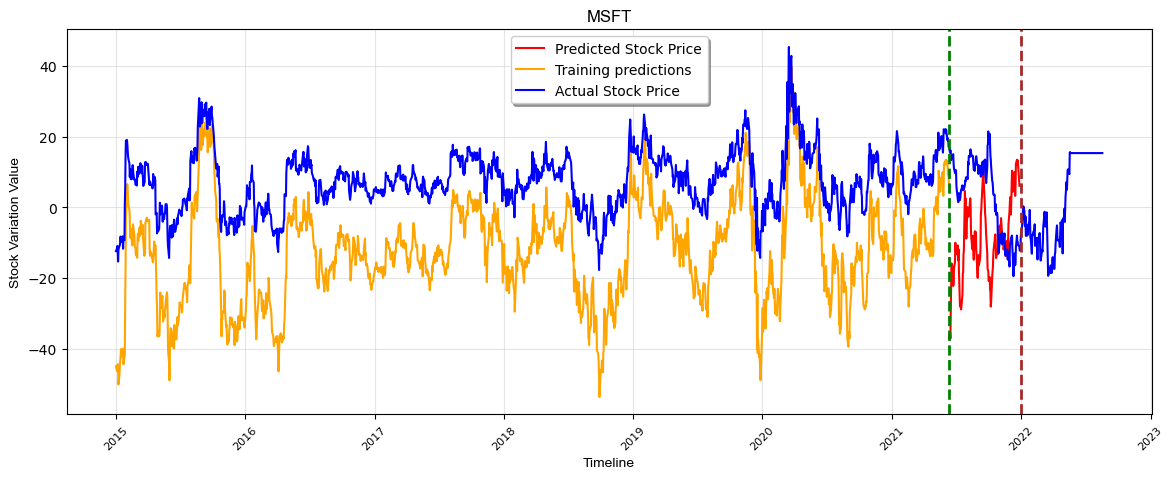

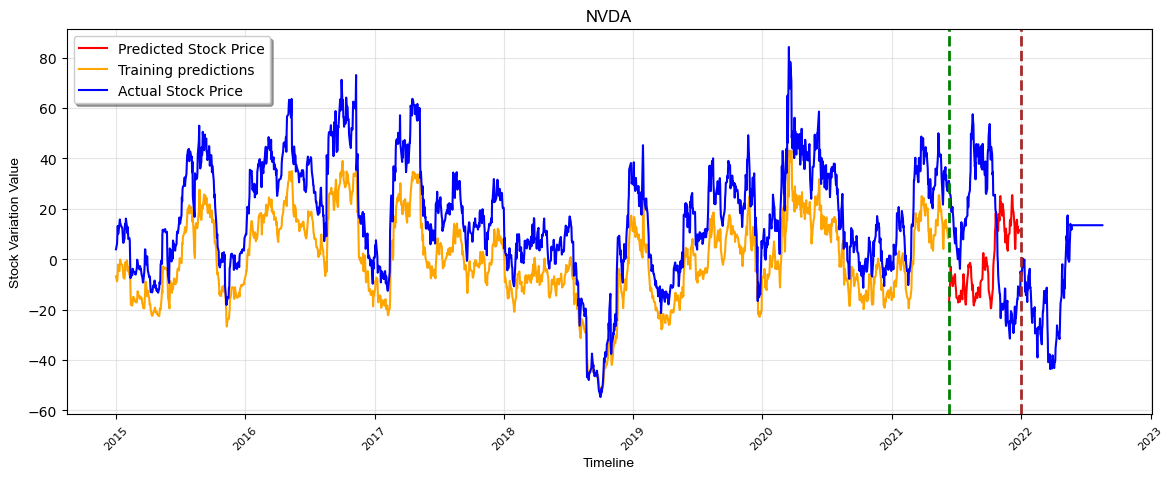

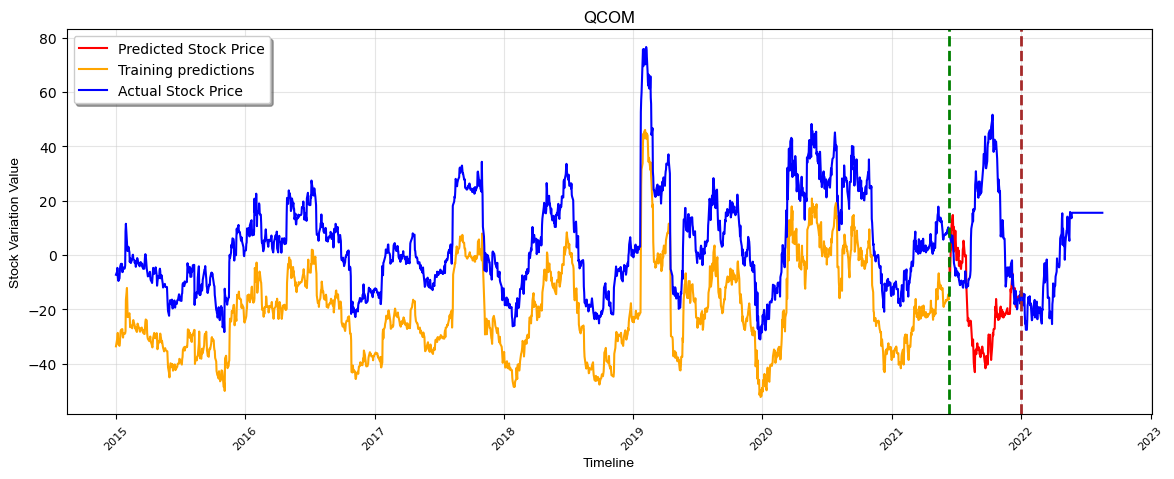

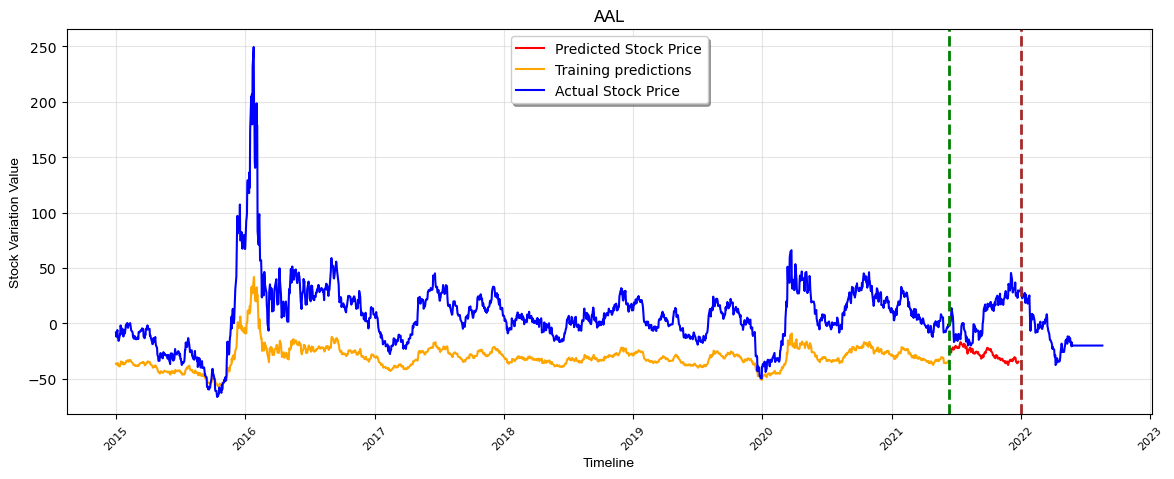

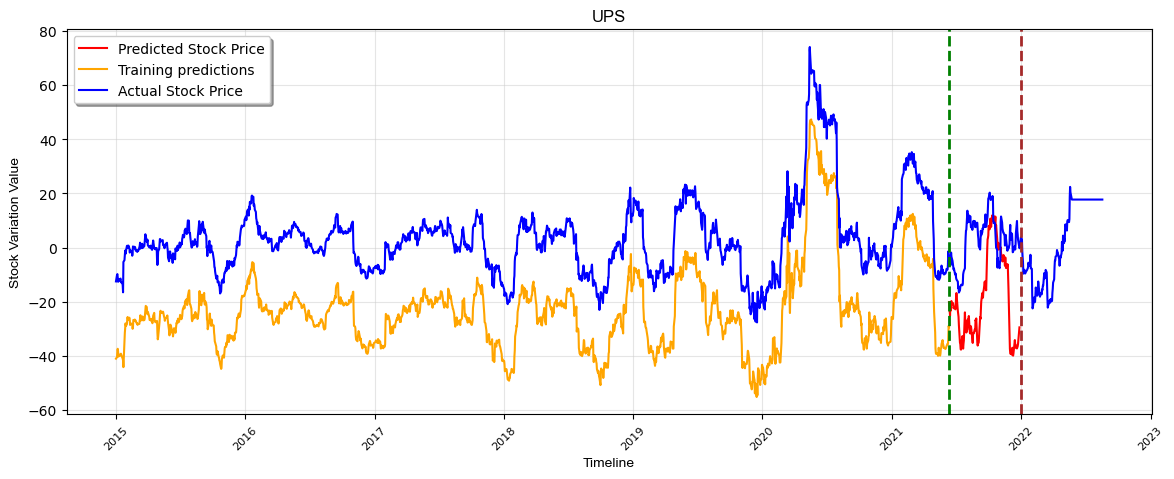

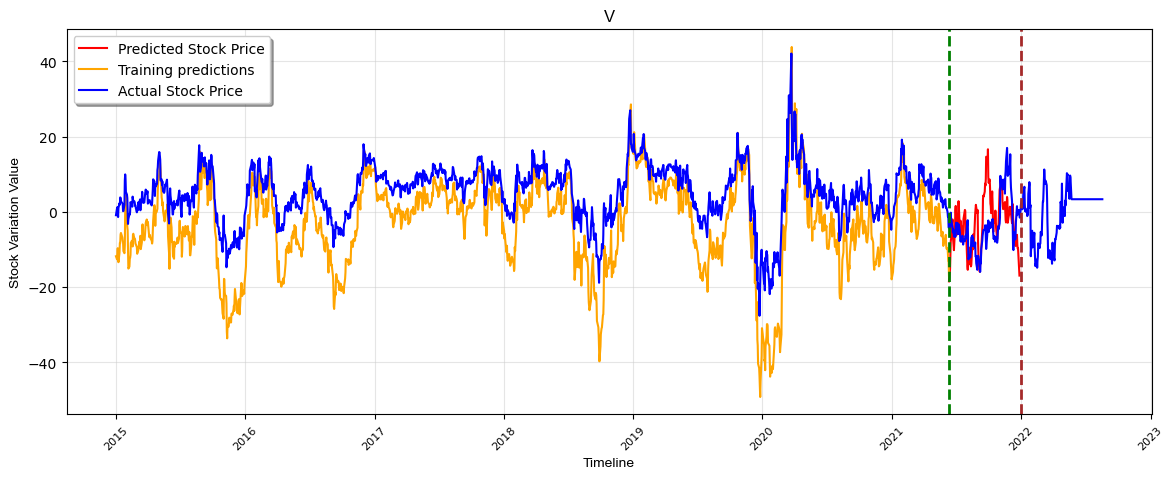

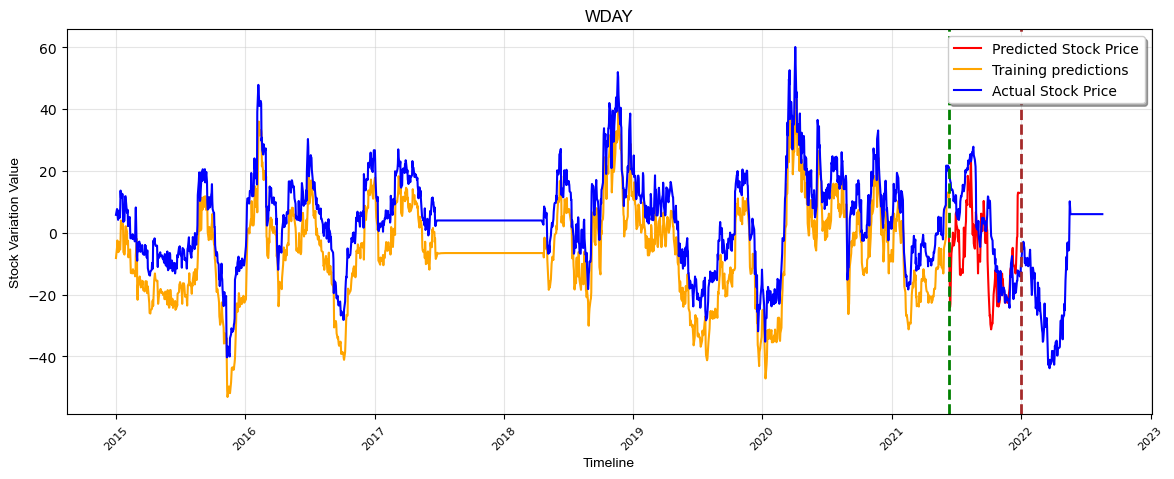

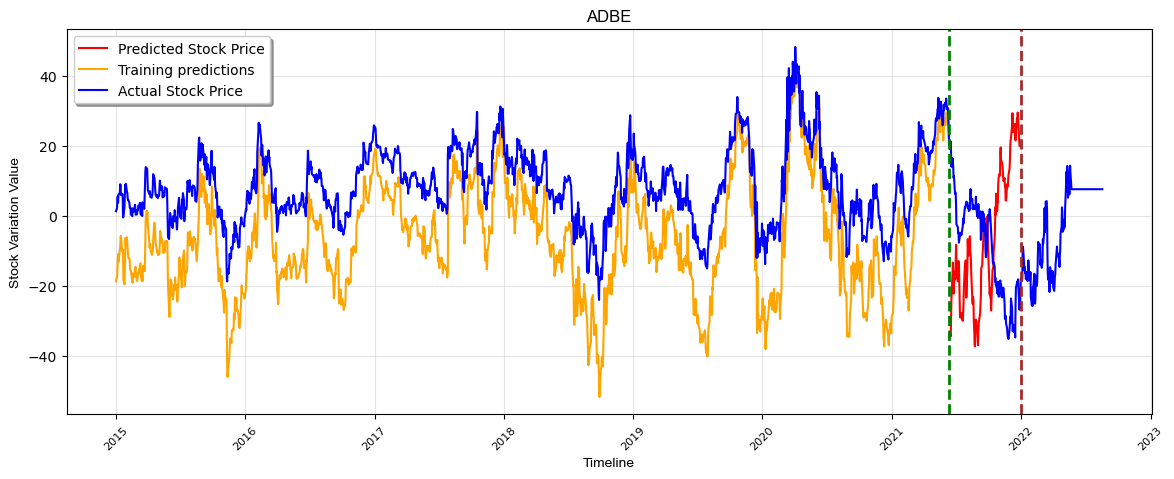

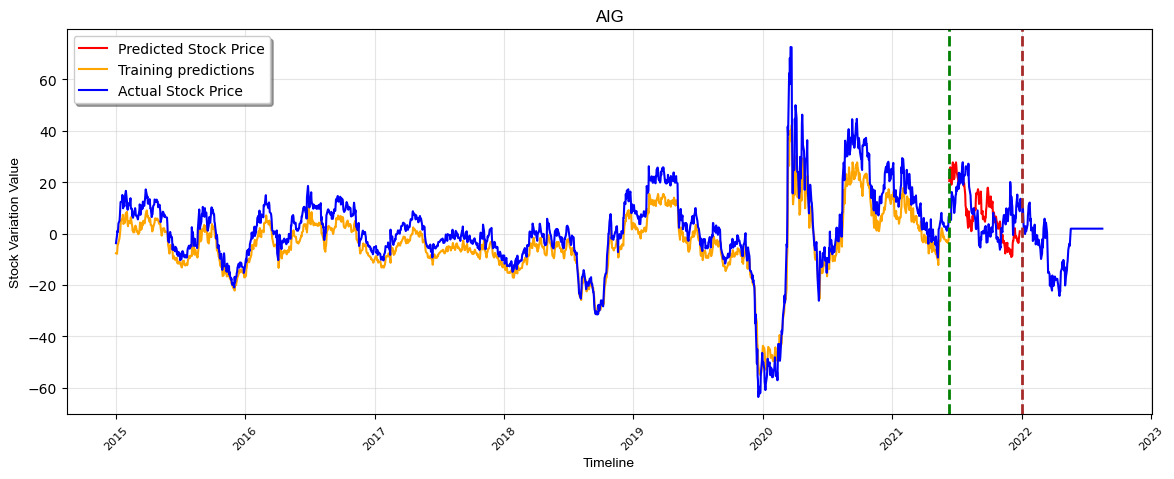

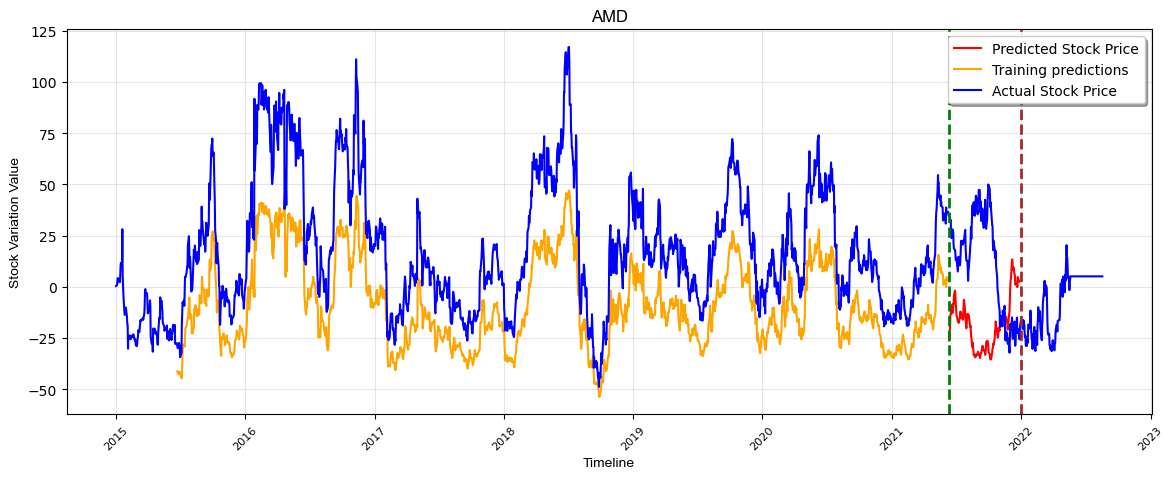

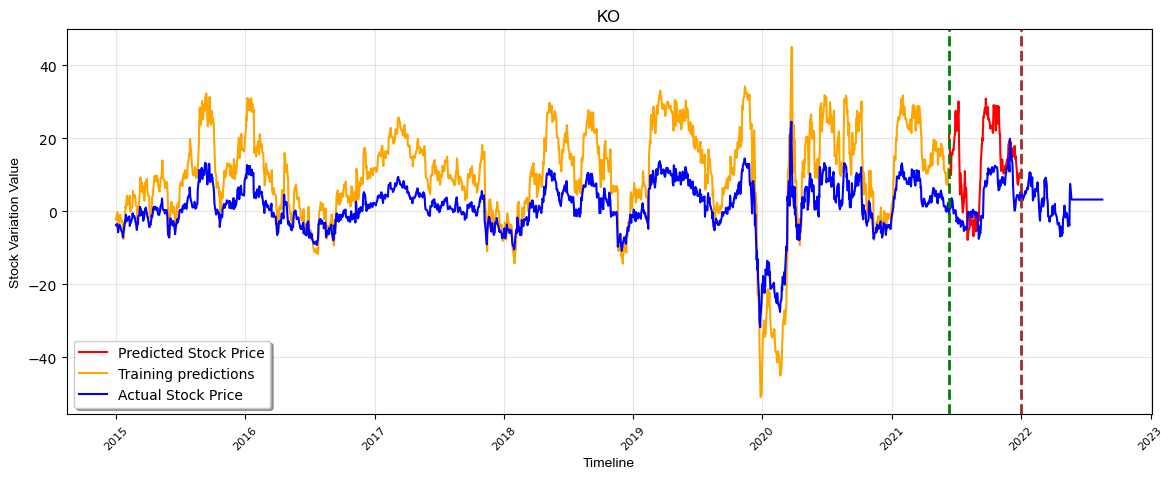

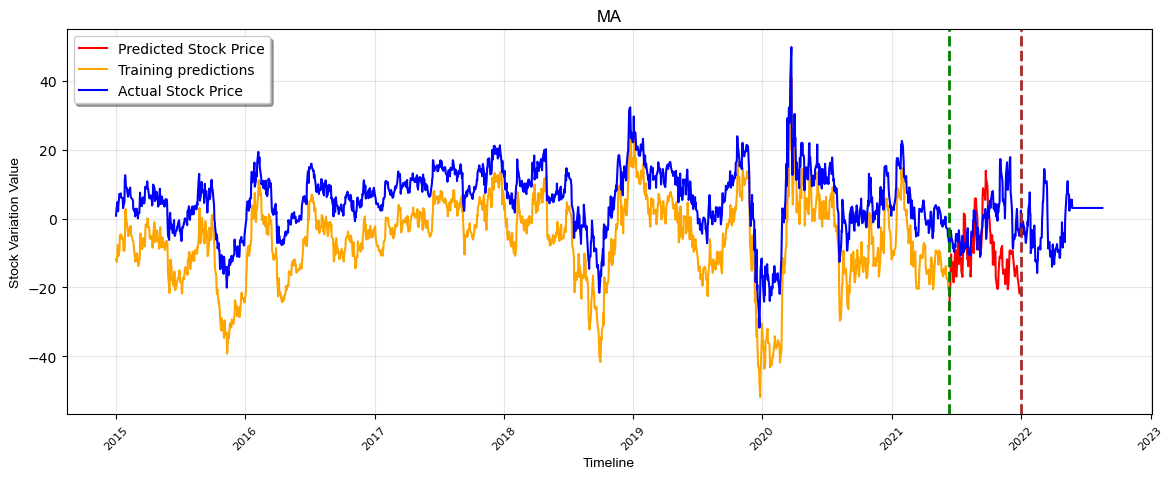

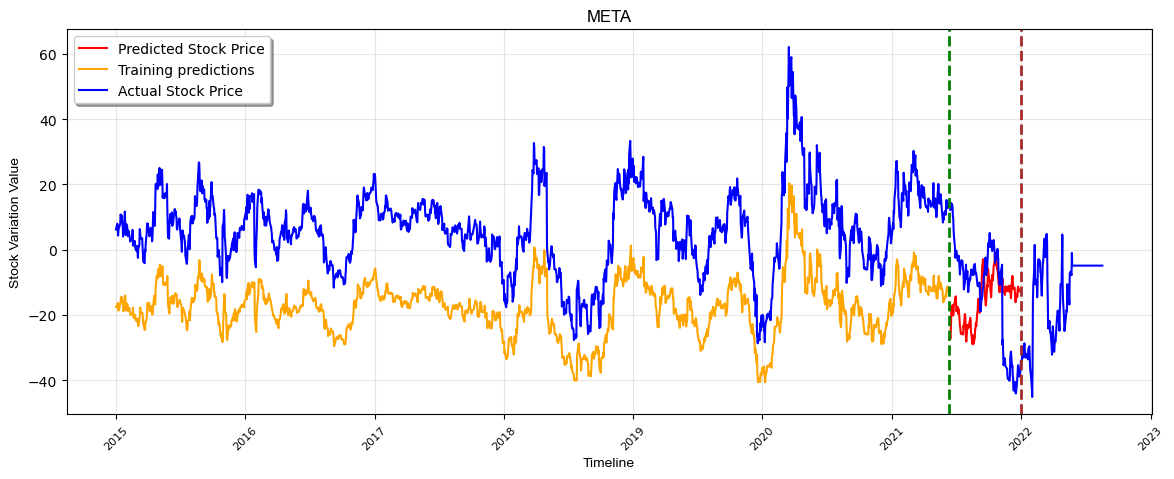

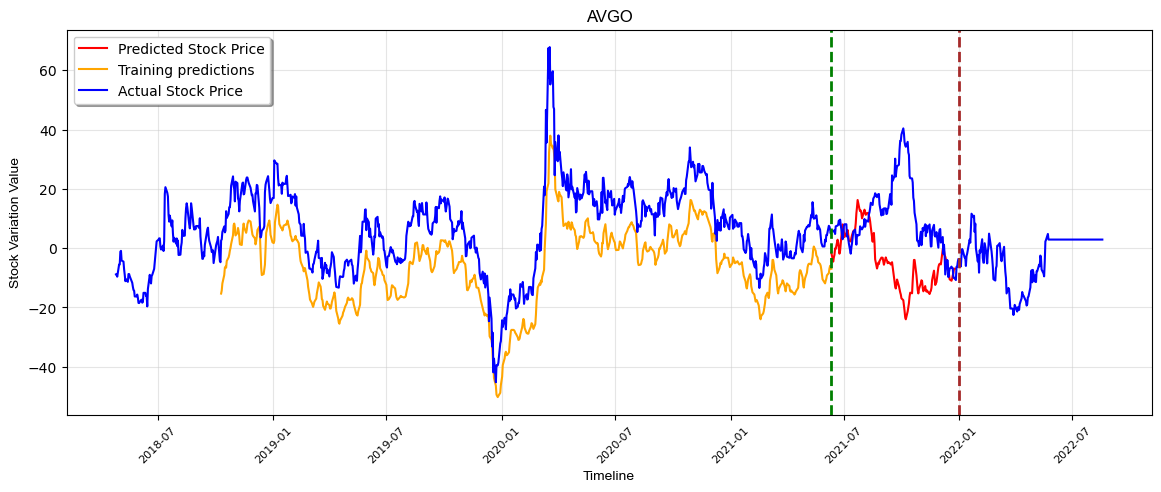

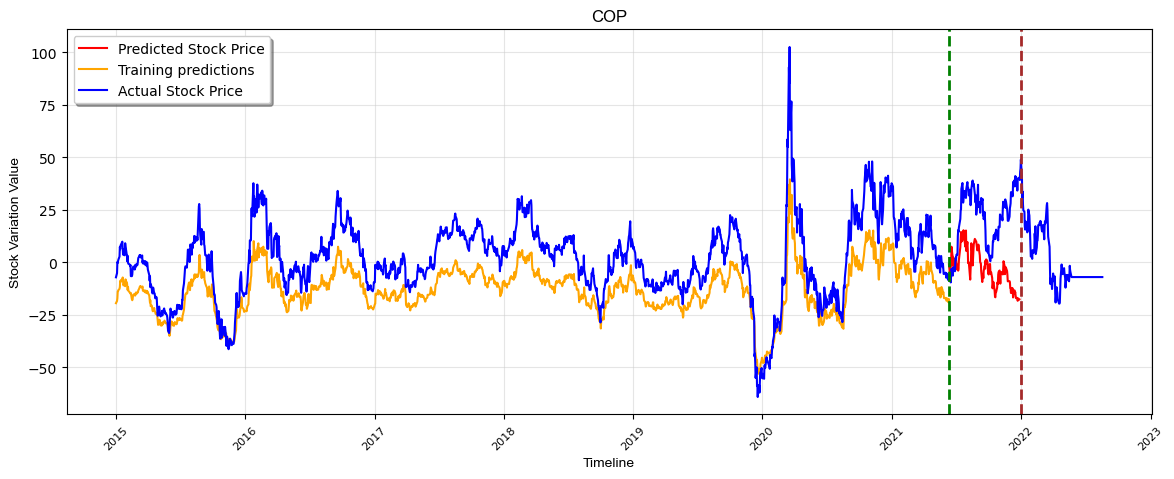

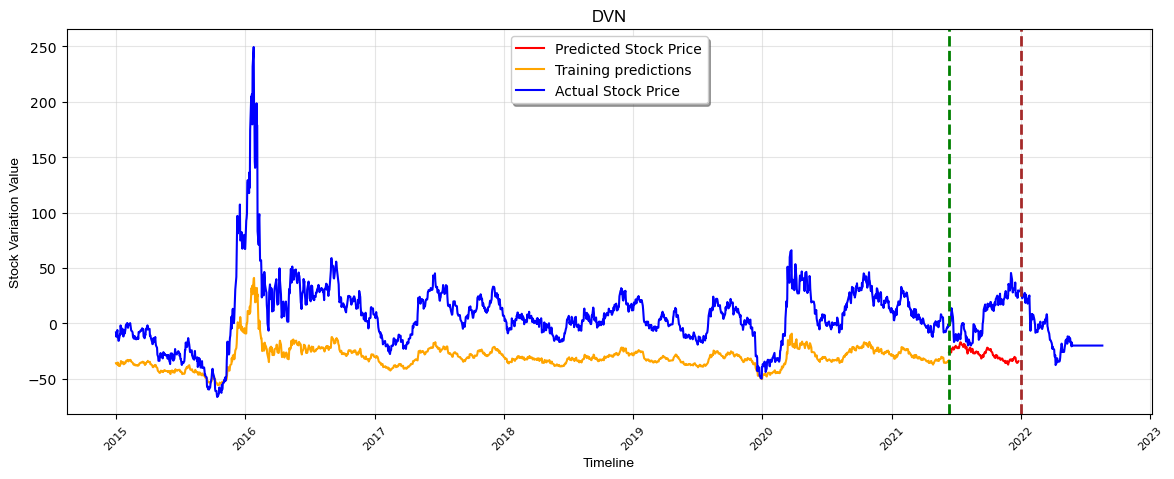

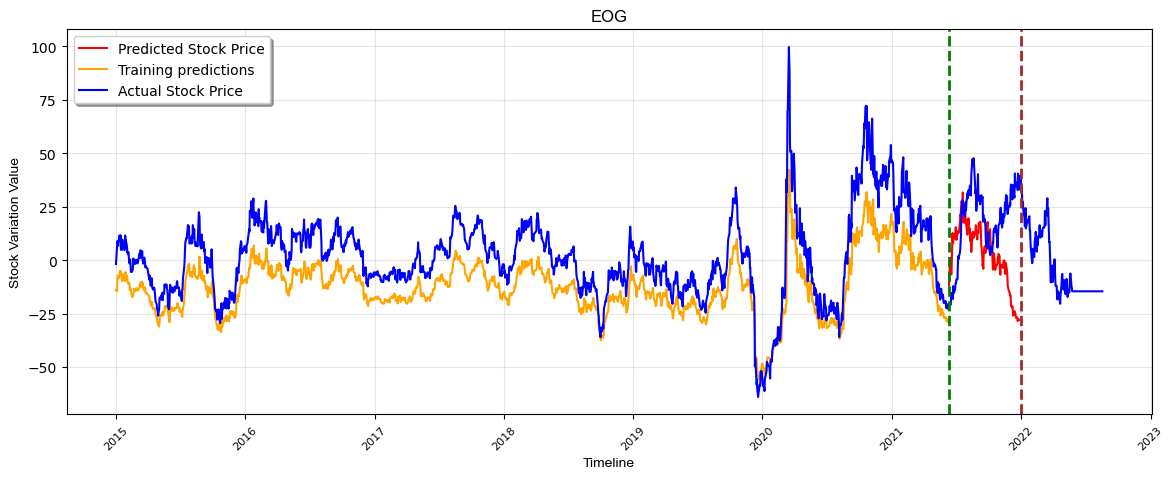

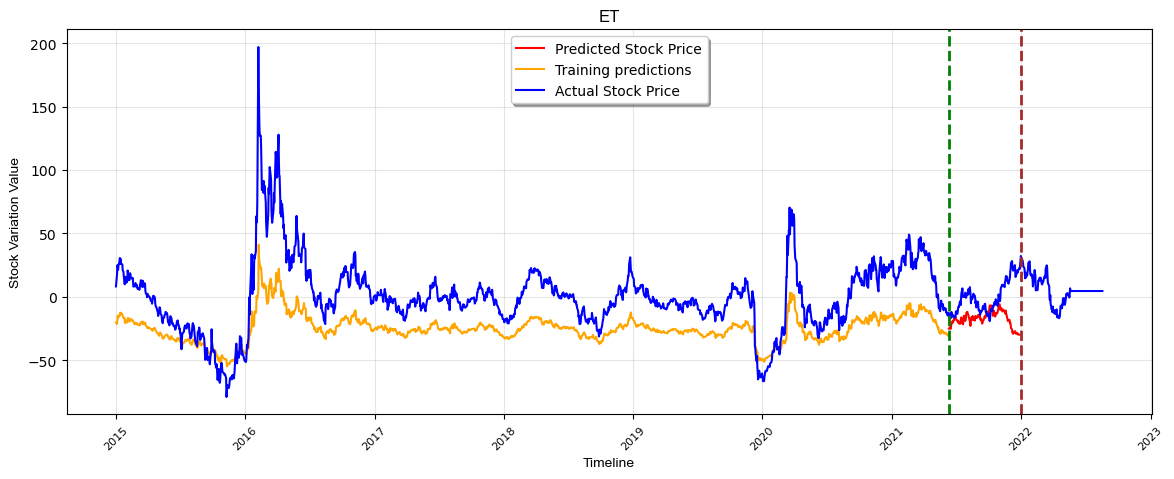

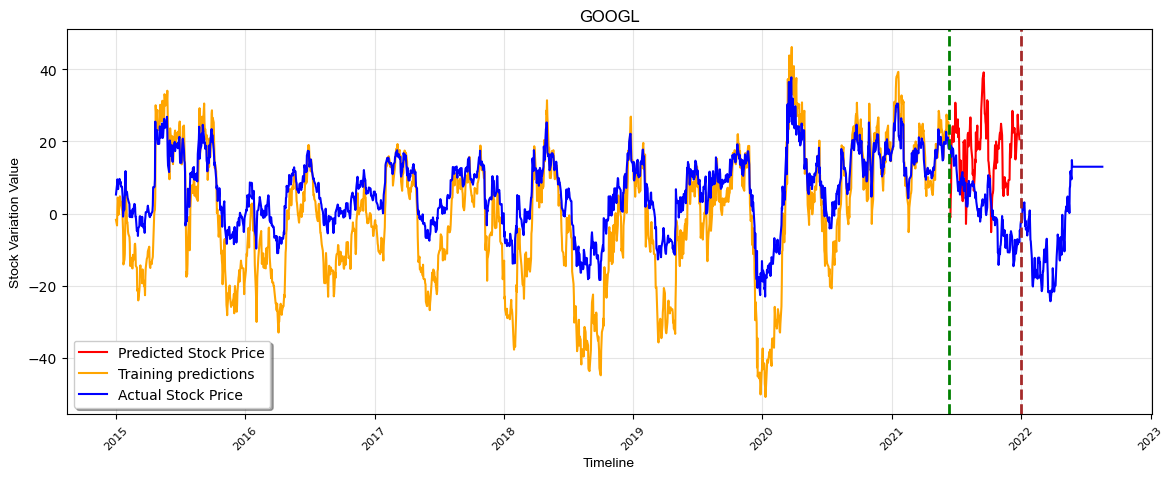

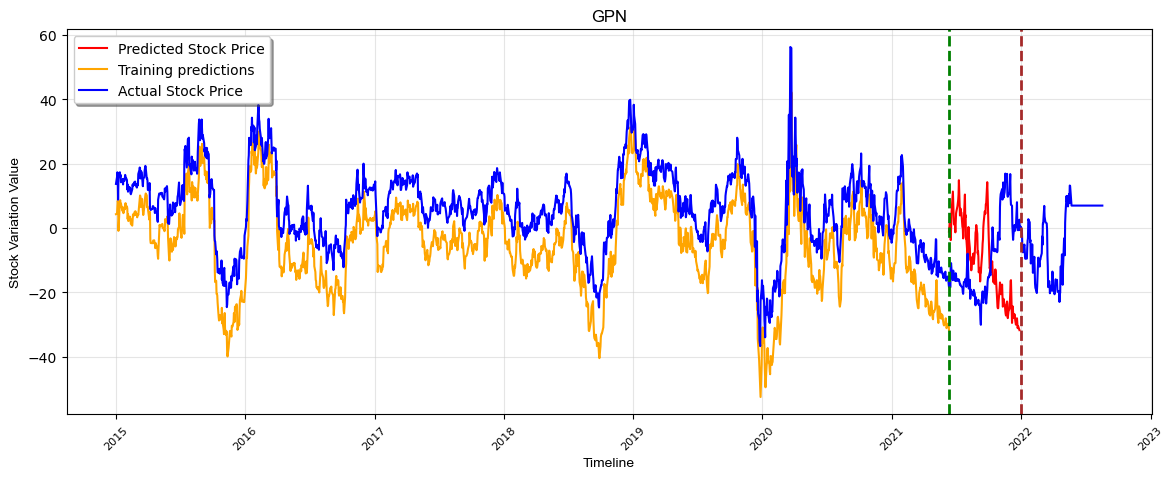

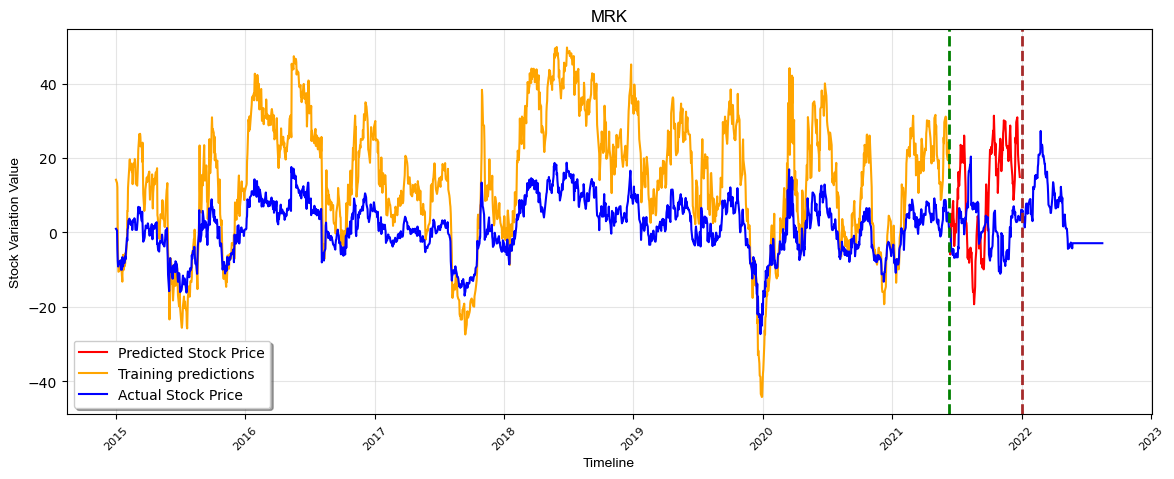

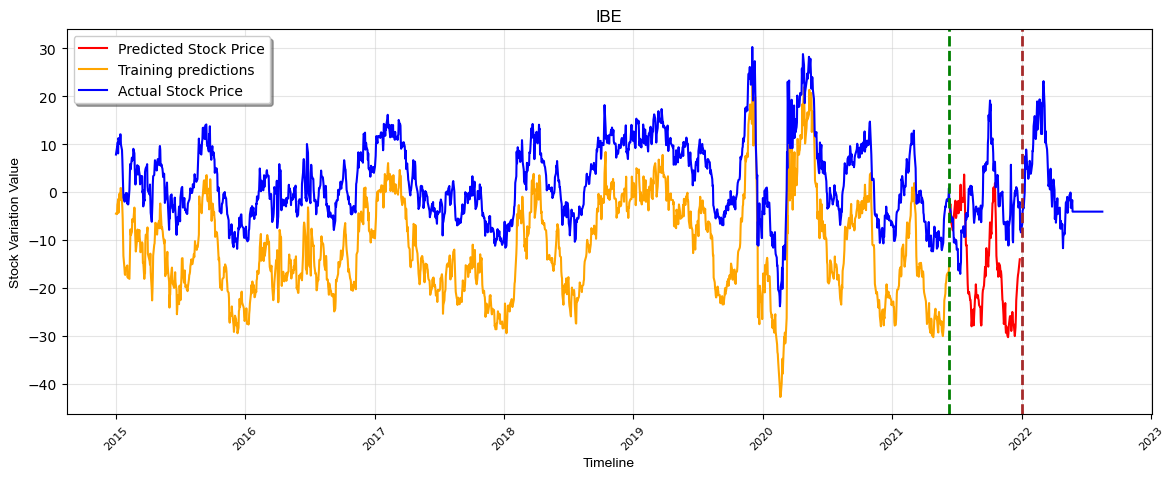

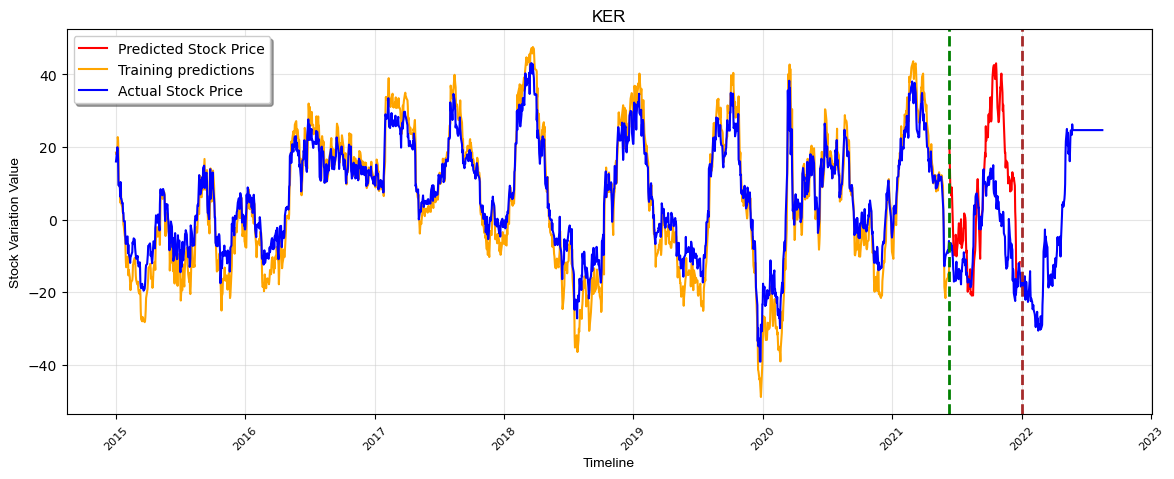

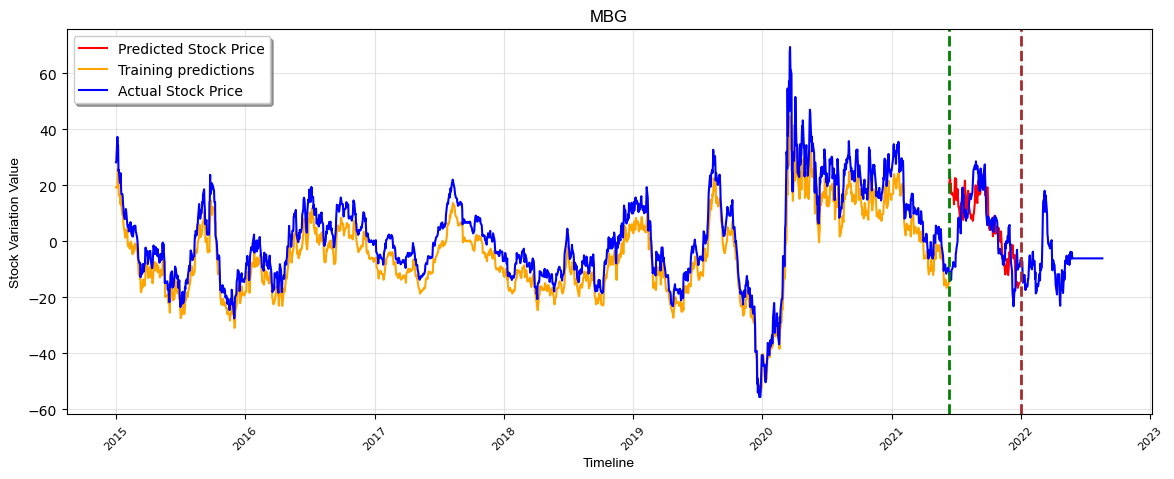

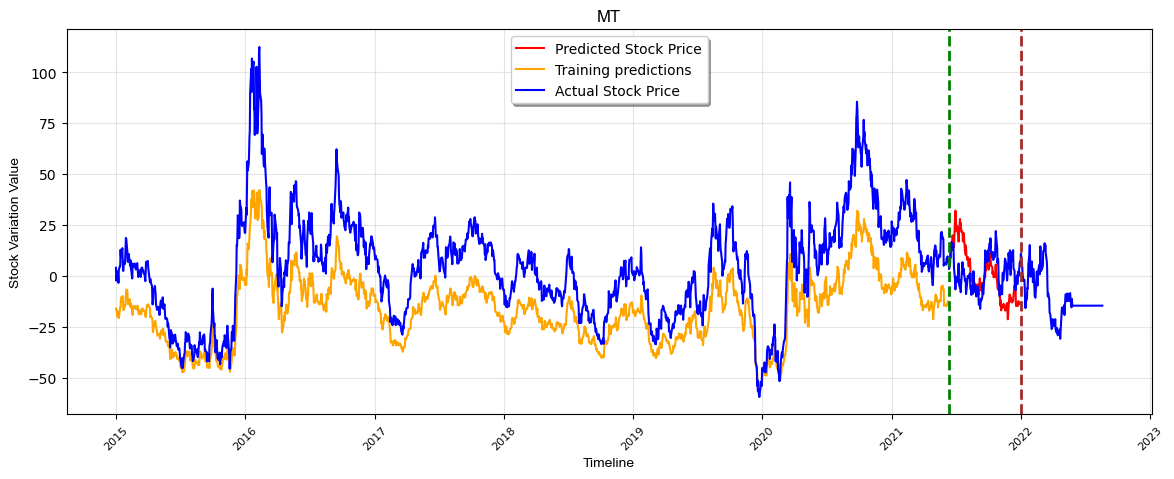

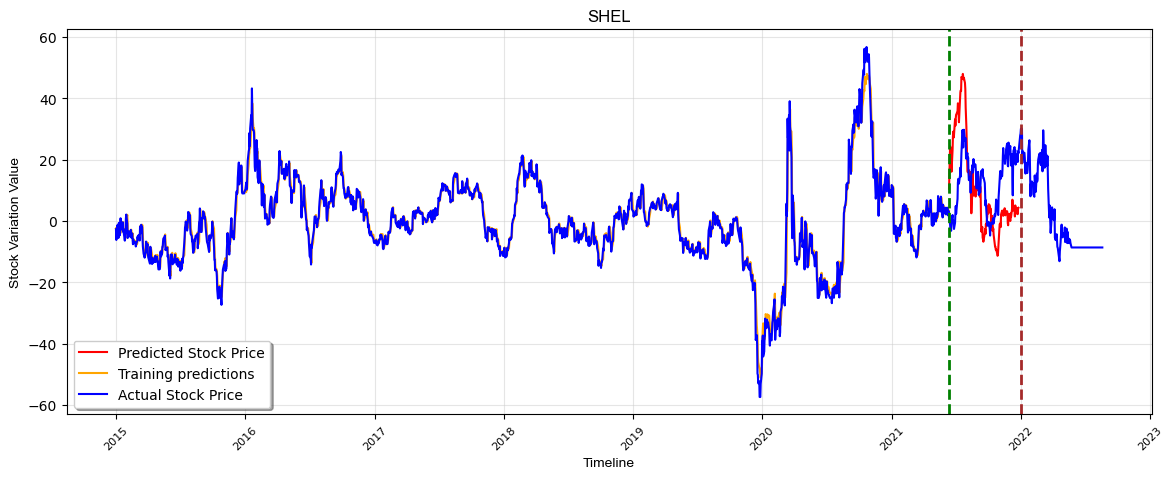

In [42]:
# Graficamos las predicciones

rcParams['figure.figsize'] = 14, 5

graph(PREDICTION_FUTURE_DF, PREDICTION_TRAIN_DF, features_dfs)

In [43]:
# Procedemos a observar el SMAPE del modelo

serror = {}
smape(PREDICTION_FUTURE_DF, serror)

-0.39572990116373696

[Volver a Contenidos](#back)

## 8. Compañias Recomendadas <a name="recomen"></a>

Se procede a correr la función que recomendará las 5 mejores empresas a invertir en función de la variación de sus acciones y su volatilidad, se le otorga una magnitud de importancia a la variación del precio y a la volatilidad a preferencia del usuario.

In [92]:
final = {}
final_result = results(final, PREDICTION_FUTURE_DF,8,20,1)
final_result

,company,price_variation_%,volatility_%,total_rank,investment_%
18,GOOGL,20.603535,1.649737,410.0,20.489755
7,ADBE,20.054869,1.909996,399.0,19.940030
20,MRK,14.894844,1.316829,297.0,14.842579
6,WDAY,12.874008,2.457456,255.0,12.743628
1,NVDA,11.549256,2.742795,228.0,11.394303
10,KO,10.382769,1.118248,207.0,10.344828
0,MSFT,6.088539,1.623298,120.0,5.997001
25,SHEL,4.345089,1.749596,85.0,4.247876


In [93]:
resume(final_result)

,income_%,volatility_%,usd_tot
0,15.01,1.83,1150.12


[Volver a Contenidos](#back)

## 9. Evaluación <a name="eval"></a>

Finalizaremos evaluando el portfolio de compañias elegidas versus acciones del Standard & Poor's 500.

In [94]:
# Creamos el benchmark a partir de las acciones del Standard & Poor's 500.

benchmark = pd.DataFrame(data={
    "index": df_index["SPX INDEX_PX_LAST"].reset_index(drop=True),
    "dates": df_index["Dates"].reset_index(drop=True),
    "name": ["benchmark"] * len(df_index),
}).dropna()

In [95]:
# Creamos nuestro portfolio a partir de las empresas seleccionadas en la sección anterior

portfolio_df={}
portfolio_df=portfolio_creation(final_result, portfolio_df, features_dfs)

In [96]:
# Calculamos el rendimiento diario del protfolio y el benchmark

all_evals_df=daily_yield(prediction_date,prediction_date_end,portfolio_df,benchmark)

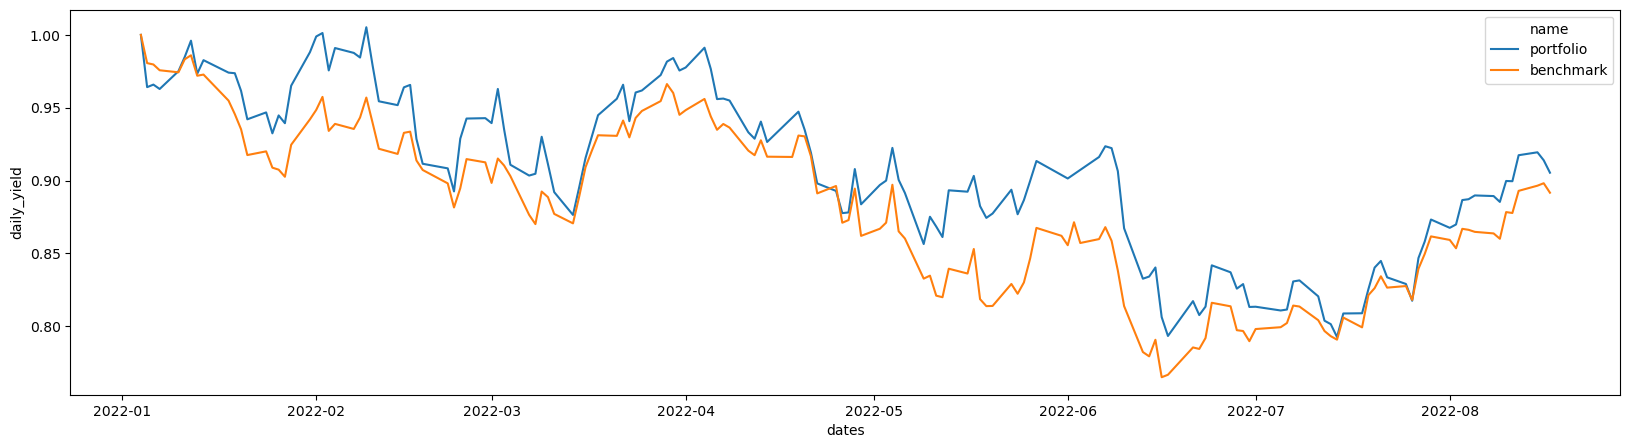

In [97]:
#Graficamos el desempeño de nuestro portfolio vs el benchmark

plt.figure(figsize=(20, 5))
sns.lineplot(data=all_evals_df, x="dates", y="daily_yield", hue="name")
plt.show()

Como podemos apreciar en el grafico que muestra nuestro portfolio creado versus el Standard & Poor's 500, de haber invertido en enero del 2022 habríamos conseguido mantener en general un rendimiento de las acciones por sobre el S&P500, lo que no quita que debido a la situación mundial que atiende el mundo durante el 2022 el valor general de las acciones caiga a lo largo del año.

 Con el presente proyecto se logró crear un modelo de machine learning que en general cumple su objetivo de intentar predecir la variación de precios de distintas empresas y aunque el modelo nunca lograra ser 100% fiable, puede utilizarse como un filtro de empresas para escoger las más interesantes de un pool que se posea, para posteriormente realizar un análisis en profundidad de las escogidas y a su vez ahorrar tiempo de análisis al poder ejecutar el modelo con un gran volumen de datos sin tener que estudiar caso a caso.

In [47]:
stop_time = time.time()
print('Time Execution:', round(stop_time - start_time,5), 'seconds')

Time Execution: 2895.15748 seconds


El tiempo de ejecución de todo el proyecto es de alrededor de 48 minutos.

In [ ]:
#Para guardar los modelos
#save_models(models):

[Volver a Contenidos](#back)